In [142]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.express as px


# library to clean text 
import re
import unicodedata

import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [143]:
def load_and_inspect_data(file_path):
    """Load dataset and perform initial inspection"""
    print("📊 LOADING AND INSPECTING DATA...")
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Basic information
    print("=== DATASET SHAPE ===")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    
    print("\n=== COLUMN NAMES ===")
    print(df.columns.tolist())
    
    print("\n=== DATA TYPES ===")
    print(df.dtypes)
    
    print("\n=== FIRST 5 ROWS ===")
    print(df.head())
    
    print("\n=== BASIC STATISTICS ===")
    print(df.describe(include='all'))
    
    return df

In [144]:
df = load_and_inspect_data("../data/raw/Competition_Dataset.csv")

📊 LOADING AND INSPECTING DATA...
=== DATASET SHAPE ===
Rows: 680826, Columns: 9

=== COLUMN NAMES ===
['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'Latitude (Y)', 'Longitude (X)']

=== DATA TYPES ===
Dates             object
Category          object
Descript          object
DayOfWeek         object
PdDistrict        object
Resolution        object
Address           object
Latitude (Y)     float64
Longitude (X)    float64
dtype: object

=== FIRST 5 ROWS ===
                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Addres

In [145]:
print("\n=== BASIC STATISTICS ===")
print(df.describe(include='all'))


=== BASIC STATISTICS ===
                      Dates       Category                      Descript  \
count                680826         680826                        680826   
unique               336145             25                           609   
top     2011-01-01 00:01:00  LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
freq                    151         157238                         53984   
mean                    NaN            NaN                           NaN   
std                     NaN            NaN                           NaN   
min                     NaN            NaN                           NaN   
25%                     NaN            NaN                           NaN   
50%                     NaN            NaN                           NaN   
75%                     NaN            NaN                           NaN   
max                     NaN            NaN                           NaN   

       DayOfWeek PdDistrict Resolution                 Addres

##### Dates
- Frequency of dates : 151 records on the most common timestamp → high event density at certain moments.
- Unique Dates: 336,145 out of 680826 → indicates multiple entries per day, possibly minute-level timestamps.
##### Category 
- Total Unique Categories: 25 → dataset covers 25 different types of crimes/incidents.
- Most Common Category: LARCENY/THEFT
- Frequency of Top Category: 157,238 → about 23% of all incidents.  Theft-related crimes dominate the dataset
##### Description
- Most Frequent Description: GRAND THEFT FROM LOCKED AUTO (53,984 times). Car-related thefts are a major issue.
##### Day of the Week
- Most Frequent Day: Friday (104,402 records). Crime activity peaks toward weekends.

##### Police Districts
- Most Common District: SOUTHERN (124,373 records). This district is the most crime-dense area.

##### Resolution
- Unique Resolutions: 17

##### Address Insights
- Most Frequent Address: 800 Block of BRYANT ST (21,053 records). A significant hotspot for incidents.

##### Geographic Coordinates
- Latitude Range: –122.51 to –120.50

- Longitude Range: 37.70 to 90.00 (likely 90 is an outlier).

- Typical Center: Latitude ≈ –122.42, Longitude ≈ 37.77 → corresponds to San Francisco area.


##### Key Observations

- High concentration of theft crimes (esp. auto-related).

- Friday and Southern District show the most activity.

- A large share of cases remain unresolved.

- Bryant Street is a top hotspot.

- Some coordinate outliers exist (90.000° longitude).


In [147]:
# Missingness %
print("=== MISSING VALUES ===")
missing = df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio")
missing.head(15)

=== MISSING VALUES ===


missing_ratio
Dates                    0.0
Category                 0.0
Descript                 0.0
DayOfWeek                0.0
PdDistrict               0.0
Resolution               0.0
Address                  0.0
Latitude (Y)             0.0
Longitude (X)            0.0

In [148]:
# Duplicates (full-row)
dup_count = df.duplicated().sum()
dup_count

11084

In [149]:
# This code checks the range of values ​​(extent) for geographic coordinates in columns:

#Longitude (X) → Longitude

#Latitude (Y) → Latitude

# Objective: To ensure that the coordinates are within the correct geographic range.
has_coords = {"Longitude (X)","Latitude (Y)"}.issubset(df.columns)
if has_coords:
    print("X range:", (df["Longitude (X)"].min(), df["Longitude (X)"].max()))
    print("Y range:", (df["Latitude (Y)"].min(), df["Latitude (Y)"].max()))

X range: (37.7078790224135, 90.0)
Y range: (-122.51364206429, -120.5)


- These values ​​are logical:

Latitude between -90 and +90

Longitude between -180 and +1- 80

This means that the coordinates are valid and can be used in map visualization.ation.

### Data Cleaning & Preprocessing

In [152]:
import re
import unicodedata
import numpy as np
import pandas as pd

def clean_and_preprocess_data(
    df: pd.DataFrame,
    *,
    min_per_class: int = 30,           # الحد الأدنى لكل فئة (يمكن تعديله)
    enforce_sf_bounds: bool = True,    # تفعيل نطاق سان فرانسيسكو أولاً
    sf_lon_range=(-123, -121),
    sf_lat_range=(36, 38)
) -> pd.DataFrame:
    """
    🧹 تنظيف وتجهيز بيانات الجرائم لاستخدامها في النمذجة والتحليل.

    - يحافظ على أحرف Unicode (العربية وغيرها) مع تطبيع خفيف.
    - يصلح احتمالية انعكاس Longitude/Latitude.
    - يرشّح الإحداثيات بنطاق جغرافي آمن ثم بالـ percentiles عند الحاجة.
    - ينشئ أعمدة نصية نظيفة وخصائص زمنية ومشتقات من العنوان.
    """

    print("🧹 DATA CLEANING & PREPROCESSING PIPELINE...")
    df_clean = df.copy()

    # ---------------------- 1) إزالة التكرارات ----------------------
    print("Removing duplicates...")
    before_dup = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Dropped {before_dup - len(df_clean)} duplicate rows")

    # ---------------------- 2) معالجة التواريخ ----------------------
    print("Processing dates...")
    if "Dates" not in df_clean.columns:
        raise KeyError("Column 'Dates' is missing.")

    df_clean["Dates"] = pd.to_datetime(df_clean["Dates"], errors="coerce")
    date_nulls = df_clean["Dates"].isna().sum()
    if date_nulls:
        df_clean = df_clean.dropna(subset=["Dates"])
        print(f"Dropped {date_nulls} rows with invalid dates")

    # ---------------------- 3) معالجة الإحداثيات ----------------------
    print("Processing coordinates...")

    # تأكد من وجود الأعمدة
    if "Longitude (X)" not in df_clean.columns or "Latitude (Y)" not in df_clean.columns:
        raise KeyError("Columns 'Longitude (X)' and/or 'Latitude (Y)' are missing.")

    # تحويل لأنواع رقمية
    df_clean["Longitude (X)"] = pd.to_numeric(df_clean["Longitude (X)"], errors="coerce")
    df_clean["Latitude (Y)"]  = pd.to_numeric(df_clean["Latitude (Y)"], errors="coerce")

    # إسقاط القيم الخالية والصفرية
    coord_null_mask = df_clean["Longitude (X)"].isna() | df_clean["Latitude (Y)"].isna()
    if coord_null_mask.any():
        print(f"Dropped {coord_null_mask.sum()} rows with null coordinates")
        df_clean = df_clean.loc[~coord_null_mask].copy()

    coord_zero_mask = (df_clean["Longitude (X)"] == 0) | (df_clean["Latitude (Y)"] == 0)
    if coord_zero_mask.any():
        print(f"Dropped {coord_zero_mask.sum()} rows with zero coordinates")
        df_clean = df_clean.loc[~coord_zero_mask].copy()

    # كشف انعكاس الأعمدة (إذا كانت Latitude ~ ±122 و Longitude ~ 37-38)
    swapped_mask = df_clean["Latitude (Y)"].abs().gt(100) & df_clean["Longitude (X)"].abs().lt(100)
    if swapped_mask.any():
        print(f"Detected possible swapped coordinates in {swapped_mask.sum()} rows → swapping X/Y columns")
        tmp = df_clean["Latitude (Y)"].copy()
        df_clean["Latitude (Y)"]  = df_clean["Longitude (X)"]
        df_clean["Longitude (X)"] = tmp

    # نطاق سان فرانسيسكو الآمن أولاً (يمنع فقد كبير بسبب التوزيع المنحاز)
    if enforce_sf_bounds:
        lon_ok = df_clean["Longitude (X)"].between(*sf_lon_range)
        lat_ok = df_clean["Latitude (Y)"].between(*sf_lat_range)
        dropped_bounds = (~(lon_ok & lat_ok)).sum()
        if dropped_bounds:
            print(f"Dropped {dropped_bounds} rows outside SF bounds {sf_lon_range} × {sf_lat_range}")
        df_clean = df_clean.loc[lon_ok & lat_ok].copy()

    # كخطوة إضافية: إزالة القيم الشاذة بالـ percentiles (لطرفي التوزيع)
    if len(df_clean) >= 1000:
        print("Removing coordinate outliers with percentiles...")
        lon_min, lon_max = df_clean["Longitude (X)"].quantile([0.001, 0.999]).tolist()
        lat_min, lat_max = df_clean["Latitude (Y)"].quantile([0.001, 0.999]).tolist()
        before_outliers = len(df_clean)
        df_clean = df_clean.loc[
            df_clean["Longitude (X)"].between(lon_min, lon_max)
            & df_clean["Latitude (Y)"].between(lat_min, lat_max)
        ].copy()
        print(f"Dropped {before_outliers - len(df_clean)} rows with extreme coordinate outliers")

    # ---------------------- 4) دالة تنظيف النص ----------------------
    PUNCT_KEEP = r""".,;:!?'"/\-\(\)\[\]&@#%+*"""

    def clean_text(text: str) -> str:
        if text is None:
            return ""
        text = str(text)

        # توحيد بعض الرموز الشائعة إلى ASCII
        replacements = {
            '“': '"', '”': '"', '„': '"', '‟': '"',
            '’': "'", '‘': "'", '‚': ',', '—': '-', '–': '-', '•': '-',
            '…': '...', '﹗': '!', '！': '!', '？': '?', '／': '/',
        }
        for k, v in replacements.items():
            text = text.replace(k, v)

        # تطبيع Unicode بشكل آمن
        text = unicodedata.normalize('NFKC', text)

        # السماح بكل أحرف يونيكود + مسافات + ترقيم آمن
        allowed = rf"[^\w\s{re.escape(PUNCT_KEEP)}]"
        text = re.sub(allowed, "", text, flags=re.UNICODE)

        # اختصار التكرارات والتنظيف النهائي
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r"[.,]{3,}", "...", text)        # نقاط متتالية
        text = re.sub(r"([/,-])\1{1,}", r"\1", text)   # تقليل تكرار / - ,
        return text

    # ---------------------- 5) تنظيف الأعمدة النصية ----------------------
    print("Cleaning text data...")
    for col in ["Category", "Descript", "DayOfWeek", "PdDistrict", "Resolution", "Address"]:
        if col in df_clean.columns:
            # Category سنعالجها بشكل خاص لاحقاً، هنا نكتفي بتنظيف لطيف لباقي الأعمدة
            if col != "Category":
                df_clean[col] = df_clean[col].astype(str).apply(clean_text)
            else:
                df_clean[col] = df_clean[col].astype(str).str.normalize("NFKC").str.strip()

        # إصدارات نظيفة للاستخدام في الـ ML
        if "Descript" in df_clean.columns:
            df_clean["Descript"] = df_clean["Descript"].astype(str).apply(clean_text)
        
        # توحيد وتطبيع عمود الفئة الأصلي مباشرة
        if "Category" in df_clean.columns:
            df_clean["Category"] = (
                df_clean["Category"]
                .astype(str)
                .str.normalize("NFKC")   # تطبيع Unicode آمن
                .str.strip()             # إزالة الفراغات
                .str.upper()             # تحويل إلى أحرف كبيرة
            )

    # لا تُسقط بقسوة: فقط الفئات الفارغة بالكامل
    before_text = len(df_clean)
    df_clean = df_clean[df_clean["Category"].ne("")].copy()
    print(f"Dropped {before_text - len(df_clean)} rows with empty category")
    # الوصف يمكن أن يكون فارغاً؛ عوّضه بسلسلة فارغة
    df_clean["Descript"] = df_clean["Descript"].fillna("")

    # ---------------------- 6) فلترة الفئات قليلة العينات ----------------------
    category_counts = df_clean["Category"].value_counts()
    kept_categories = category_counts[category_counts >= min_per_class].index
    removed_cats = category_counts.index.difference(kept_categories)
    print(f"Kept {len(kept_categories)} categories (>= {min_per_class}/class), removed {len(removed_cats)}")

    df_ml_ready = df_clean[df_clean["Category"].isin(kept_categories)].copy()

    # ---------------------- 7) اشتقاقات زمنية ----------------------
    print("Creating time-based features...")
    df_ml_ready["Hour"]         = df_ml_ready["Dates"].dt.hour
    df_ml_ready["Month"]        = df_ml_ready["Dates"].dt.month
    df_ml_ready["Year"]         = df_ml_ready["Dates"].dt.year
    df_ml_ready["DayOfWeek_num"]= df_ml_ready["Dates"].dt.dayofweek
    df_ml_ready["DayOfMonth"]   = df_ml_ready["Dates"].dt.day
    df_ml_ready["WeekOfYear"]   = df_ml_ready["Dates"].dt.isocalendar().week.astype(int)

    def get_time_of_day(h):
        if 5 <= h < 12:   return "Morning"
        if 12 <= h < 17:  return "Afternoon"
        if 17 <= h < 21:  return "Evening"
        return "Night"

    df_ml_ready["TimeOfDay"] = df_ml_ready["Hour"].apply(get_time_of_day)

    def get_season(m):
        if m in (12, 1, 2):  return "Winter"
        if m in (3, 4, 5):   return "Spring"
        if m in (6, 7, 8):   return "Summer"
        return "Fall"

    df_ml_ready["Season"] = df_ml_ready["Month"].apply(get_season)

    # ---------------------- 8) اشتقاقات من العنوان ----------------------
    def get_address_type(address: str) -> str:
        if not isinstance(address, str):
            address = str(address or "")
        a = address.lower()
        if "block" in a: return "Block"
        if "/" in a and (" st" in a or " street" in a or " ave" in a or " av" in a):
            return "Intersection"
        if " ave" in a or " avenue" in a or a.endswith(" ave"):
            return "Avenue"
        if " st" in a or " street" in a or a.endswith(" st"):
            return "Street"
        return "Other"

    if "Address" in df_ml_ready.columns:
        df_ml_ready["AddressType"] = df_ml_ready["Address"].apply(get_address_type)
    else:
        df_ml_ready["AddressType"] = "Other"

    # ---------------------- 9) فحوصات ختامية ----------------------
    print("\n=== FINAL DATA QUALITY CHECK ===")
    print(f"Final dataset shape: {df_ml_ready.shape}")
    print(f"Date range: {df_ml_ready['Dates'].min()} to {df_ml_ready['Dates'].max()}")
    print(f"Unique crime categories: {df_ml_ready['Category'].nunique()}")
    if "PdDistrict" in df_ml_ready.columns:
        print(f"Unique police districts: {df_ml_ready['PdDistrict'].nunique()}")
    missing_values = df_ml_ready.isna().sum().sum()
    print(f"Remaining missing values: {missing_values}")
    print(f"Longitude range: [{df_ml_ready['Longitude (X)'].min():.4f}, {df_ml_ready['Longitude (X)'].max():.4f}]")
    print(f"Latitude range:  [{df_ml_ready['Latitude (Y)'].min():.4f}, {df_ml_ready['Latitude (Y)'].max():.4f}]")
    print("Data cleaning and preprocessing completed successfully!")

    return df_ml_ready


In [153]:
df = clean_and_preprocess_data(df)

🧹 DATA CLEANING & PREPROCESSING PIPELINE...
Removing duplicates...
Dropped 11084 duplicate rows
Processing dates...
Processing coordinates...
Detected possible swapped coordinates in 669742 rows → swapping X/Y columns
Dropped 55 rows outside SF bounds (-123, -121) × (36, 38)
Removing coordinate outliers with percentiles...
Dropped 1600 rows with extreme coordinate outliers
Cleaning text data...
Dropped 0 rows with empty category
Kept 25 categories (>= 30/class), removed 0
Creating time-based features...

=== FINAL DATA QUALITY CHECK ===
Final dataset shape: (668087, 18)
Date range: 2003-01-06 00:01:00 to 2015-05-13 23:53:00
Unique crime categories: 25
Unique police districts: 10
Remaining missing values: 0
Longitude range: [-122.5103, -122.3656]
Latitude range:  [37.7087, 37.8097]
Data cleaning and preprocessing completed successfully!


In [154]:
# 7) حفظ نسخة معالجة
OUT = Path("../data/processed/cityx_clean.parquet")
OUT.parent.mkdir(parents=True, exist_ok=True)
df.to_parquet(OUT, index=False)

In [155]:
df.head()

Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

   Latitude (Y)  Longitude (X)  Hour  Month  Year  DayOfWeek_num  DayOfMonth  \
0     37.774599    -122.425892    23      5  2015              2          13   
1     37.774599    -122.425892    23      5  2015              2          13   
2     37.800414    -122.424363    23      5  2015              2          13   
3     37.800873    -122.426995    23      5  2015              2          13   
4     37.771541    -122.438738    23      5  2015              2          13   

   WeekOfYear TimeOfDay  Season   AddressType  
0          20     Night  Spring  Intersection  
1          20     Night  Spring  Intersection  
2          20     Night  Spring  Intersection  
3          20     Night  Spring         Block  
4          20     Night  Spring         Block

In [174]:
# 4. Summary Statistics & EDA
# =============================================================================
def generate_summary_statistics(df):
    """Generate comprehensive summary statistics"""
    print("📈 GENERATING SUMMARY STATISTICS...")
    
    print("=== CRIME SUMMARY ===")
    print(f"Total crime incidents: {len(df)}")
    print(f"Most common crime category: {df['Category'].mode()[0]}")
    print(f"Most active police district: {df['PdDistrict'].mode()[0]}")
    print(f"Most common day of week: {df['DayOfWeek'].mode()[0]}")
    
    print("\n=== TOP 10 CRIME CATEGORIES ===")
    top_crimes = df['Category'].value_counts().head(10)
    print(top_crimes)
    
    print("\n=== CRIMES BY POLICE DISTRICT ===")
    district_crimes = df['PdDistrict'].value_counts()
    print(district_crimes)
    
    print("\n=== CRIMES BY DAY OF WEEK ===")
    day_counts = df['DayOfWeek'].value_counts()
    print(day_counts)
    
    print("\n=== HOURLY DISTRIBUTION ===")
    hour_counts = df.groupby("Hour").size()
    print(hour_counts.head(24))

    print("\n=== MONTHLY TREND ===")
    if {"Year","Month"}.issubset(df.columns):
        monthly = df.groupby(["Year","Month"]).size().reset_index(name="Incidents")
    print(monthly.tail(12))
    
    return {
        'top_crimes': top_crimes,
        'district_crimes': district_crimes,
        'day_counts': day_counts,
        'hour_counts': hour_counts,
        'monthly_Incidents_count': monthly
    }

In [176]:
summary_stats = generate_summary_statistics(df_clean)

📈 GENERATING SUMMARY STATISTICS...
=== CRIME SUMMARY ===
Total crime incidents: 11029
Most common crime category: /
Most active police district: 
Most common day of week: 

=== TOP 10 CRIME CATEGORIES ===
Category
/    11029
Name: count, dtype: int64

=== CRIMES BY POLICE DISTRICT ===
PdDistrict
    11029
Name: count, dtype: int64

=== CRIMES BY DAY OF WEEK ===
DayOfWeek
     5876
s    5153
Name: count, dtype: int64

=== HOURLY DISTRIBUTION ===
Hour
0     1483
1      127
2       89
3       46
4       44
5       31
6       70
7      146
8      527
9      689
10     568
11     527
12    1512
13     704
14     638
15     756
16     658
17     632
18     433
19     350
20     308
21     233
22     238
23     220
dtype: int64

=== MONTHLY TREND ===
     Year  Month  Incidents
137  2014      6         28
138  2014      7         26
139  2014      8         30
140  2014      9         53
141  2014     10         44
142  2014     11         33
143  2014     12         38
144  2015      1      

In [178]:
# 5. Visualization - Crime Trends & Patterns
# =============================================================================
def create_visualizations(df, summary_stats):
    """Create comprehensive visualizations"""
    print("📊 CREATING VISUALIZATIONS...")
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('CityX Crime Analysis - Key Insights', fontsize=16, fontweight='bold')
    
    # 1. Top Crime Categories
    top_categories = df['Category'].value_counts().head(10)
    axes[0,0].barh(top_categories.index, top_categories.values)
    axes[0,0].set_title('Top 10 Crime Categories')
    axes[0,0].set_xlabel('Number of Incidents')
    
    # 2. Crimes by Police District
    district_counts = df['PdDistrict'].value_counts()
    axes[0,1].bar(district_counts.index, district_counts.values)
    axes[0,1].set_title('Crimes by Police District')
    axes[0,1].set_xlabel('District')
    axes[0,1].set_ylabel('Number of Incidents')
    plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Crimes by Day of Week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = df['DayOfWeek'].value_counts().reindex(day_order)
    axes[0,2].bar(day_counts.index, day_counts.values)
    axes[0,2].set_title('Crimes by Day of Week')
    axes[0,2].set_xlabel('Day of Week')
    axes[0,2].set_ylabel('Number of Incidents')
    plt.setp(axes[0,2].xaxis.get_majorticklabels(), rotation=45)
    
    # 4. Crimes by Hour of Day
    hour_counts = df['Hour'].value_counts().sort_index()
    axes[1,0].plot(hour_counts.index, hour_counts.values, marker='o')
    axes[1,0].set_title('Crimes by Hour of Day')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Number of Incidents')
    axes[1,0].grid(True)
    
    # 5. Crimes by Time of Day
    time_counts = df['TimeOfDay'].value_counts()
    axes[1,1].pie(time_counts.values, labels=time_counts.index, autopct='%1.1f%%')
    axes[1,1].set_title('Crimes by Time of Day')
    
    # 6. Resolution Status
    resolution_counts = df['Resolution'].value_counts().head(8)
    axes[1,2].barh(resolution_counts.index, resolution_counts.values)
    axes[1,2].set_title('Top Resolution Types')
    axes[1,2].set_xlabel('Number of Incidents')
    
    # 7. Monthly Trend
    plt.figure(figsize=(12, 6))
    monthly_trend = df.groupby(['Year', 'Month']).size().reset_index(name='Count')
    monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year', 'Month']].assign(DAY=1))
    plt.plot(monthly_trend['Date'], monthly_trend['Count'])
    plt.title('Monthly Crime Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

📊 CREATING VISUALIZATIONS...


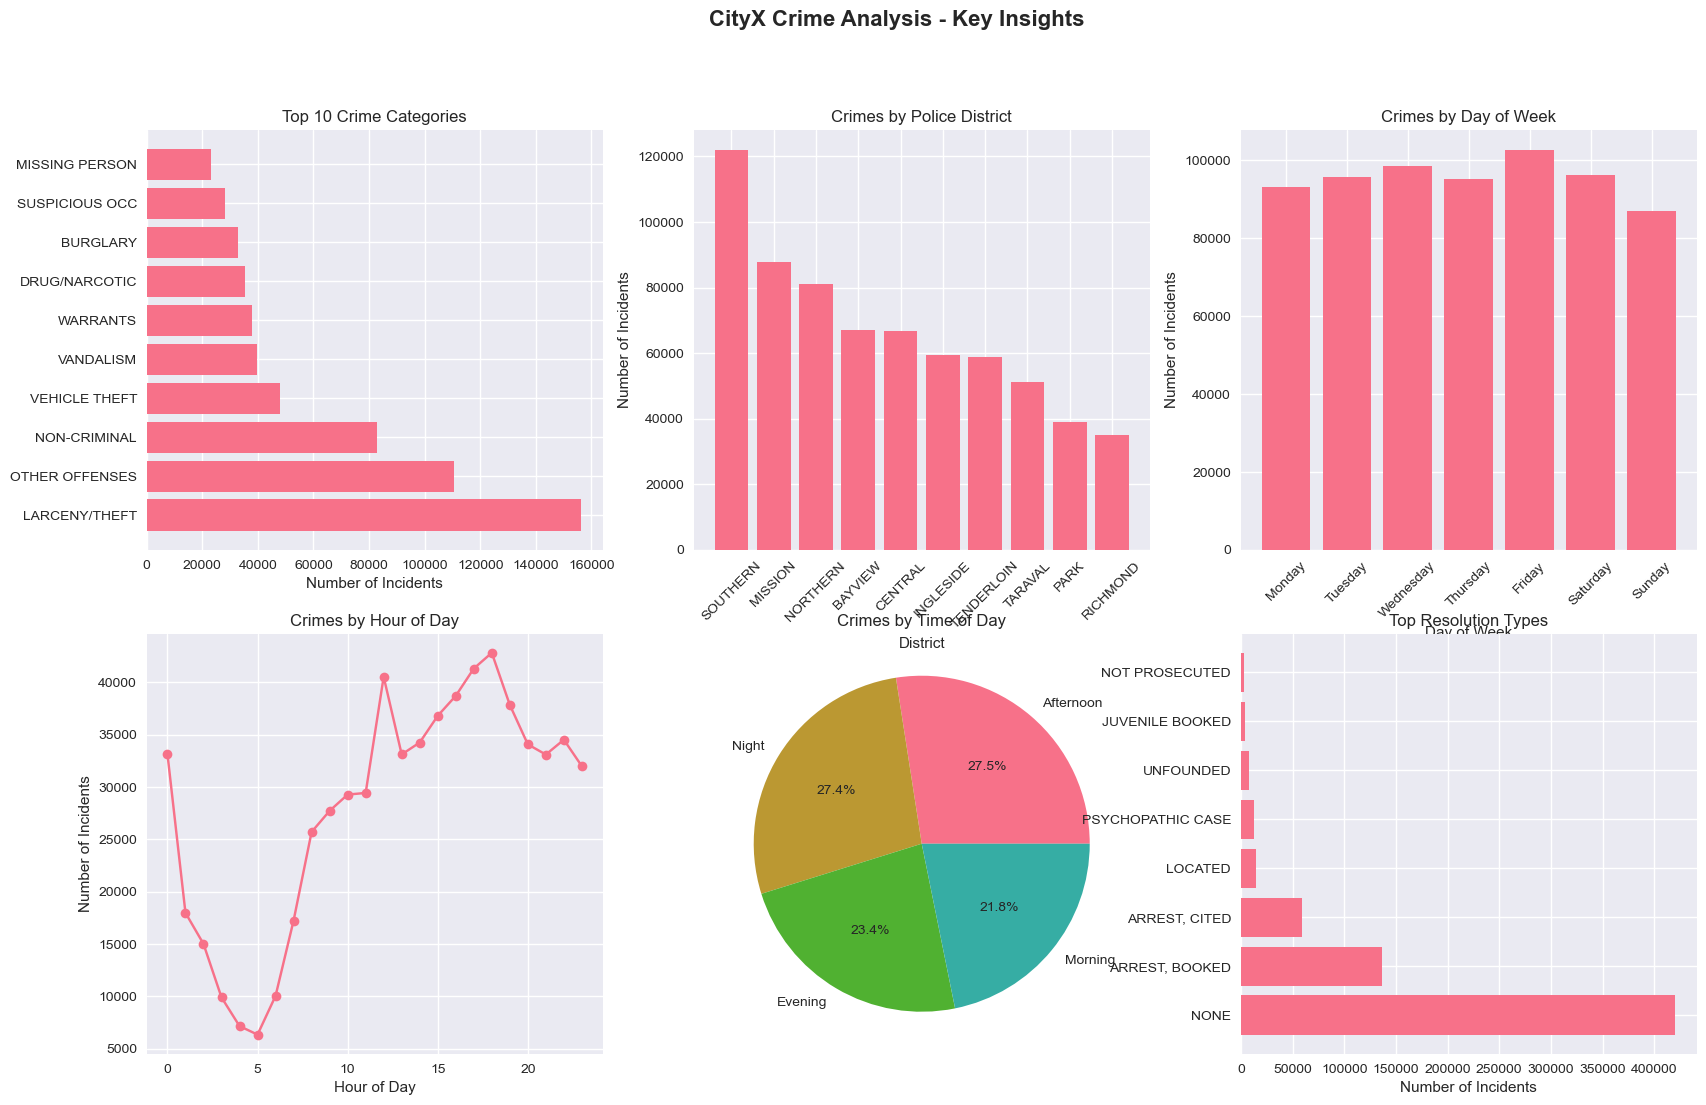

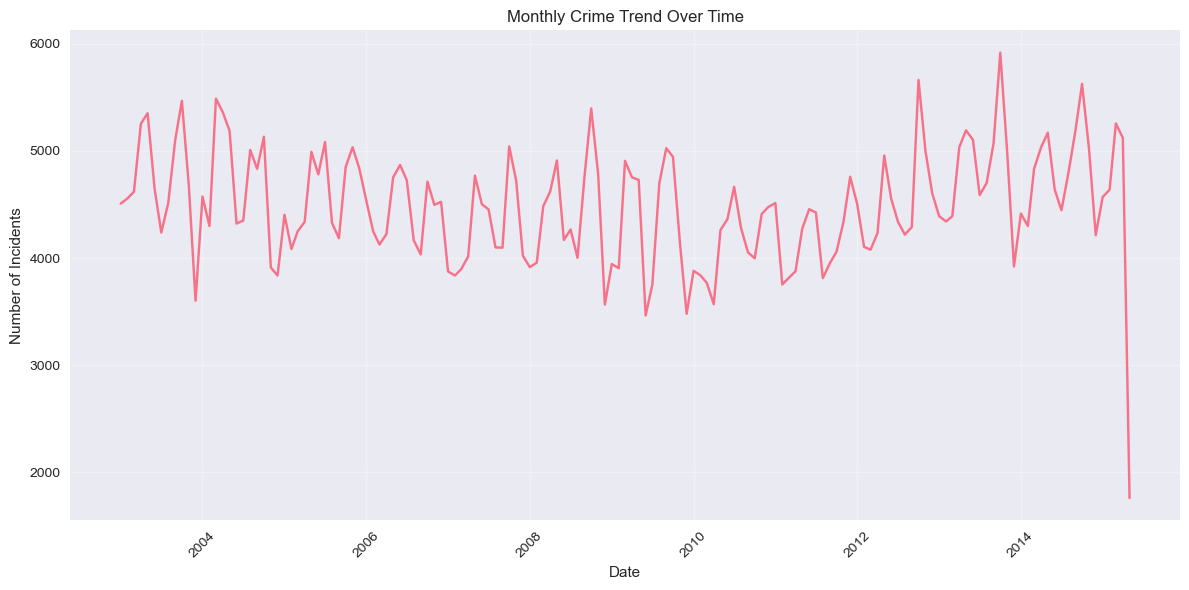

In [180]:
create_visualizations(df, summary_stats)

{'lat_abs_median': 37.775420706711, 'lon_abs_median': 122.416577792446}


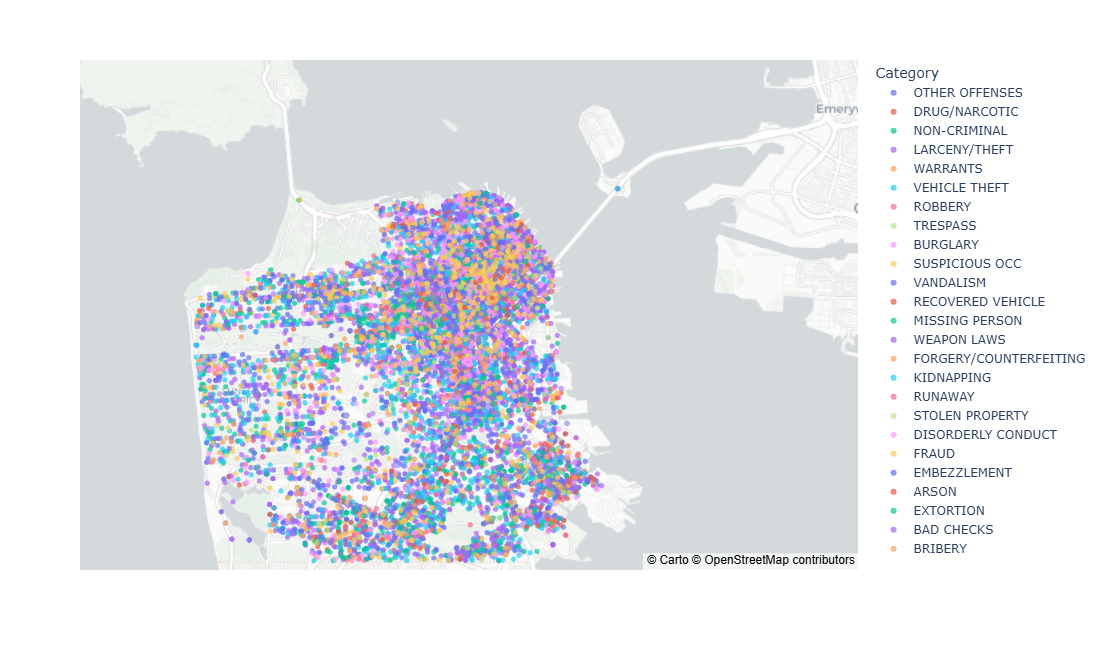

In [182]:
import pandas as pd
import plotly.express as px

LAT_COL = "Latitude (Y)"
LON_COL = "Longitude (X)"

# 1) تحويل لأرقام
g = df.copy()
g[LAT_COL] = pd.to_numeric(g[LAT_COL], errors="coerce")
g[LON_COL] = pd.to_numeric(g[LON_COL], errors="coerce")

# 2) تشخيص سريع
lat_med = g[LAT_COL].abs().median()
lon_med = g[LON_COL].abs().median()
print({"lat_abs_median": lat_med, "lon_abs_median": lon_med})

# 3) إصلاح تلقائي إذا كانا مقلوبين
#    (العرض يجب أن يكون ≤ 90، الطول ≤ 180)
if (lat_med > 90) and (lon_med <= 90):
    print("Detected swapped columns → fixing (lat ↔ lon).")
    g[[LAT_COL, LON_COL]] = g[[LON_COL, LAT_COL]]

# 4) تنظيف خفيف (بدون قتل كل البيانات)
g = g.dropna(subset=[LAT_COL, LON_COL])
g = g[g[LAT_COL].between(-90, 90) & g[LON_COL].between(-180, 180)]

# لو dataset ضخم خذ عينة للرسم
if len(g) > 20000:
    g = g.sample(20000, random_state=42)

# 5) رسم الخريطة (مع مركز واضح)
if g.empty:
    raise ValueError("Still no points after fix. تأكد من أسماء الأعمدة وقيمها الفعلية.")
center_lat = float(g[LAT_COL].median())
center_lon = float(g[LON_COL].median())

hover_cols = [c for c in ["Category","Descript","PdDistrict","Dates","Address"] if c in g.columns]

fig = px.scatter_mapbox(
    g, lat=LAT_COL, lon=LON_COL,
    color="Category" if "Category" in g.columns else None,
    hover_name="Category" if "Category" in g.columns else None,
    hover_data=hover_cols,
    opacity=0.7, height=650, zoom=11,
    mapbox_style="carto-positron"
)
fig.update_layout(mapbox_center={"lat": center_lat, "lon": center_lon})
fig.update_traces(marker=dict(size=6))
fig.show()
